In [1]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns

import datetime as datetime
import matplotlib.dates as dates
import matplotlib.pyplot as plt

from contextlib import contextmanager
from time import time
from tqdm import tqdm


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

import datetime
from datetime import date

In [2]:
df = pd.read_csv("MariSehat.csv")

In [3]:
date2=[]
for item in df['Date']:
    item2=item.split('/')
    month=int(item2[0])
    day=int(item2[1])
    year=int(item2[2])
    date2+=[datetime.date(year,month,day)]
df['Date']=date2
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
data = df.drop(['City or Regency','Name','Item','Kind','Hidden','Location ISO Code',
                'Province','Country','Continent','Island','Time Zone','Special Status',
                'Total Regencies','Total Cities','Total Districts','Total Urban Villages',
                'Total Rural Villages','New Cases per Million','Total Cases per Million',
                'New Deaths per Million','Total Deaths per Million','Case Fatality Rate',
                'Case Recovered Rate','Growth Factor of New Cases','Growth Factor of New Deaths'],axis = 1)
data = data.fillna(0)
data.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude
0,2020-01-08,Jawa Timur,9,3,1,5,9,5,10,-6,Province,47803,40479023,846.78,112.732941,-7.723346
1,2020-01-09,Jawa Timur,0,1,23,-24,9,6,33,-30,Province,47803,40479023,846.78,112.732941,-7.723346
2,2020-01-10,Jawa Timur,0,1,14,-15,9,7,47,-45,Province,47803,40479023,846.78,112.732941,-7.723346
3,2020-01-11,Jawa Timur,0,3,8,-11,9,10,55,-56,Province,47803,40479023,846.78,112.732941,-7.723346
4,2020-01-12,Jawa Timur,0,3,1,-4,9,13,56,-60,Province,47803,40479023,846.78,112.732941,-7.723346


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16283 entries, 0 to 16282
Data columns (total 16 columns):
Date                  16283 non-null datetime64[ns]
Location              16283 non-null object
New Cases             16283 non-null int64
New Deaths            16283 non-null int64
New Recovered         16283 non-null int64
New Active Cases      16283 non-null int64
Total Cases           16283 non-null int64
Total Deaths          16283 non-null int64
Total Recovered       16283 non-null int64
Total Active Cases    16283 non-null int64
Location Level        16283 non-null object
Area (km2)            16283 non-null int64
Population            16283 non-null int64
Population Density    16283 non-null float64
Longitude             16283 non-null float64
Latitude              16283 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(10), object(2)
memory usage: 2.0+ MB


In [6]:
data1 = data[data['Location Level'] != 'Country']

In [7]:
newest = data1.drop_duplicates(subset='Location', keep="last")
newest.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude
16249,2021-07-09,Aceh,80,13,108,-41,20140,862,15541,3737,Province,57956,5247257,90.54,96.910522,4.225615
16250,2021-07-09,Bali,674,6,0,668,54079,1618,46181,6280,Province,5780,4216171,729.43,115.131714,-8.369472
16251,2021-07-09,Banten,514,4,49,461,61689,1457,50554,9678,Province,9663,10722374,1109.64,106.109004,-6.456736
16252,2021-07-09,Bengkulu,101,0,67,34,11671,194,9530,1947,Province,19919,1999539,100.38,102.338421,-3.533584
16253,2021-07-09,DKI Jakarta,13112,138,15022,-2048,636383,9270,527060,100053,Province,664,10846145,16334.31,106.836118,-6.204699


In [8]:
newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude
16253,2021-07-09,DKI Jakarta,13112,138,15022,-2048,636383,9270,527060,100053,Province,664,10846145,16334.31,106.836118,-6.204699
16257,2021-07-09,Jawa Barat,7399,160,4974,2265,440379,6008,348694,85677,Province,35378,45161325,1276.55,107.603708,-6.920432
16258,2021-07-09,Jawa Tengah,4530,202,3042,1286,285348,12562,223706,49080,Province,32801,36364072,1108.64,110.201115,-7.259097
16259,2021-07-09,Jawa Timur,2530,168,1727,635,189705,13635,160296,15774,Province,47803,40479023,846.78,112.732941,-7.723346
16263,2021-07-09,Kalimantan Timur,1021,18,433,570,83762,2003,73864,7895,Province,129067,3552191,27.52,116.468440,0.453858
16274,2021-07-09,Riau,504,16,299,189,74899,2019,67986,4894,Province,87024,6074100,69.80,101.805109,0.511648
16254,2021-07-09,Daerah Istimewa Yogyakarta,1665,44,902,719,72560,1892,54352,16316,Province,3133,3631015,1158.90,110.444878,-7.894502
16276,2021-07-09,Sulawesi Selatan,511,7,119,385,67280,1021,62671,3588,Province,46717,9426885,201.78,120.162056,-3.731081
16251,2021-07-09,Banten,514,4,49,461,61689,1457,50554,9678,Province,9663,10722374,1109.64,106.109004,-6.456736
16280,2021-07-09,Sumatera Barat,718,10,275,433,55675,1259,48840,5576,Province,42013,5519245,131.37,100.465062,-0.850253


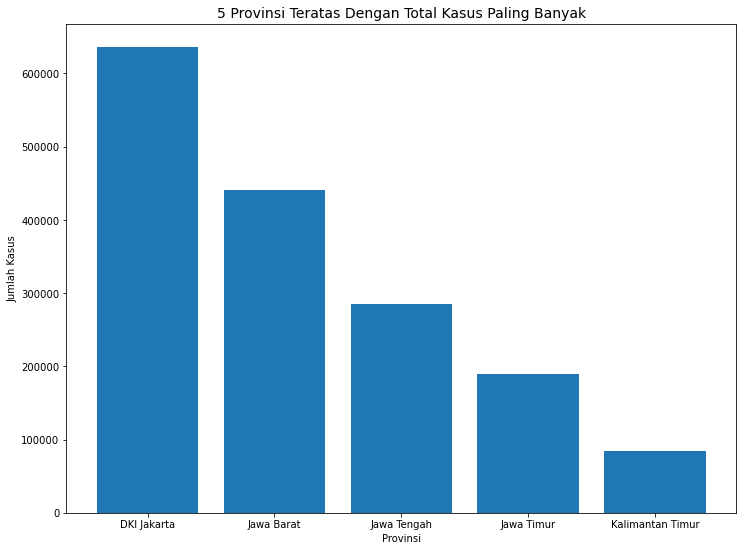

In [9]:
plt.figure(figsize=(12,9))
plt.bar(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Location'].values[:5], newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Total Cases'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kasus Paling Banyak', fontsize=14)
plt.xlabel('Provinsi')
plt.ylabel('Jumlah Kasus')
plt.show()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


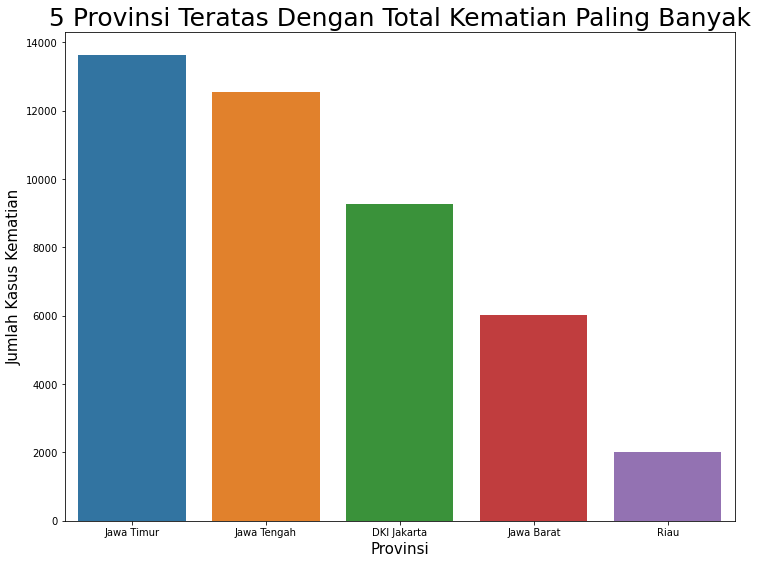

In [10]:
plt.figure(figsize=(12,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Deaths'], ascending=False)['Location'].values[:5],  newest[newest.Location != 'Indonesia'].sort_values(by=['Total Deaths'], ascending=False)['Total Deaths'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kematian Paling Banyak', fontsize=25)
plt.xlabel('Provinsi', fontsize=15)
plt.ylabel('Jumlah Kasus Kematian', fontsize=15)
plt.show()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


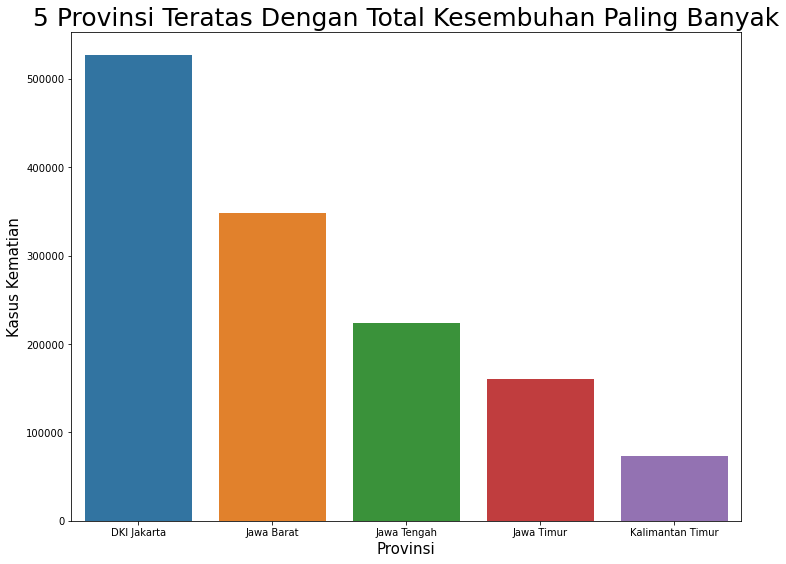

In [11]:
plt.figure(figsize=(12,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Recovered'], ascending=False)['Location'].values[:5],  newest[newest.Location != 'Indonesia'].sort_values(by=['Total Recovered'], ascending=False)['Total Recovered'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kesembuhan Paling Banyak', fontsize=25)
plt.xlabel('Provinsi', fontsize=15)
plt.ylabel('Kasus Kematian', fontsize=15)
plt.show()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


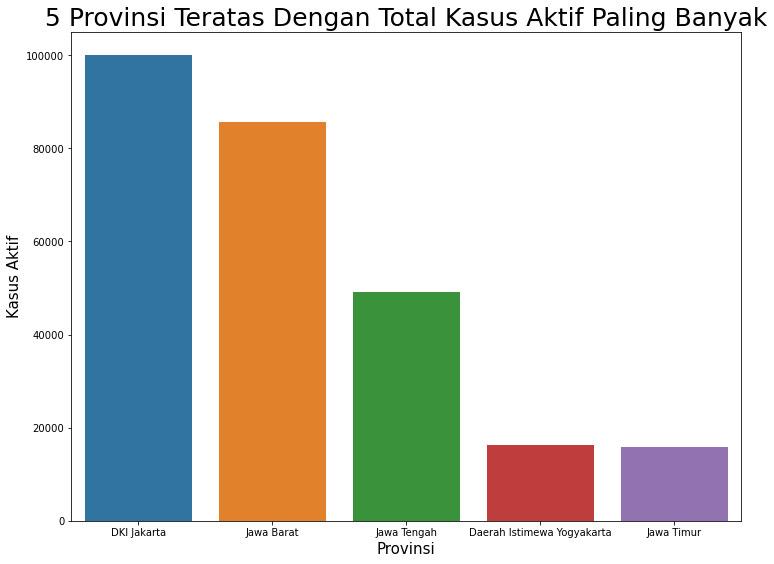

In [12]:
plt.figure(figsize=(12,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Active Cases'], ascending=False)['Location'].values[:5],  newest[newest.Location != 'Indonesia'].sort_values(by=['Total Active Cases'], ascending=False)['Total Active Cases'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kasus Aktif Paling Banyak', fontsize=25)
plt.xlabel('Provinsi', fontsize=15)
plt.ylabel('Kasus Aktif', fontsize=15)
plt.show()

In [13]:
jakarta = data[data.Location == 'DKI Jakarta'].tail(7).copy()
jakarta

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude
16049,2021-07-03,DKI Jakarta,9701,16,5682,4003,570106,8531,479013,82562,Province,664,10846145,16334.31,106.836118,-6.204699
16083,2021-07-04,DKI Jakarta,10485,66,5816,4603,580591,8597,484829,87165,Province,664,10846145,16334.31,106.836118,-6.204699
16117,2021-07-05,DKI Jakarta,10902,120,6597,4185,591493,8717,491426,91350,Province,664,10846145,16334.31,106.836118,-6.204699
16151,2021-07-06,DKI Jakarta,9439,137,6100,3202,600932,8854,497526,94552,Province,664,10846145,16334.31,106.836118,-6.204699
16185,2021-07-07,DKI Jakarta,9365,142,3655,5568,610297,8996,501181,100120,Province,664,10846145,16334.31,106.836118,-6.204699
16219,2021-07-08,DKI Jakarta,12974,136,10857,1981,623271,9132,512038,102101,Province,664,10846145,16334.31,106.836118,-6.204699
16253,2021-07-09,DKI Jakarta,13112,138,15022,-2048,636383,9270,527060,100053,Province,664,10846145,16334.31,106.836118,-6.204699


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


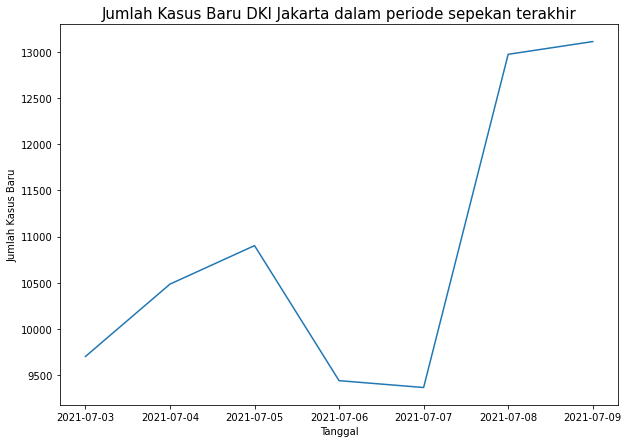

In [14]:
plt.figure(figsize=(10,7))
plt.plot(jakarta['Date'].values ,jakarta['New Cases'].values)
plt.title('Jumlah Kasus Baru DKI Jakarta dalam periode sepekan terakhir', fontsize=15)
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kasus Baru')
plt.show()

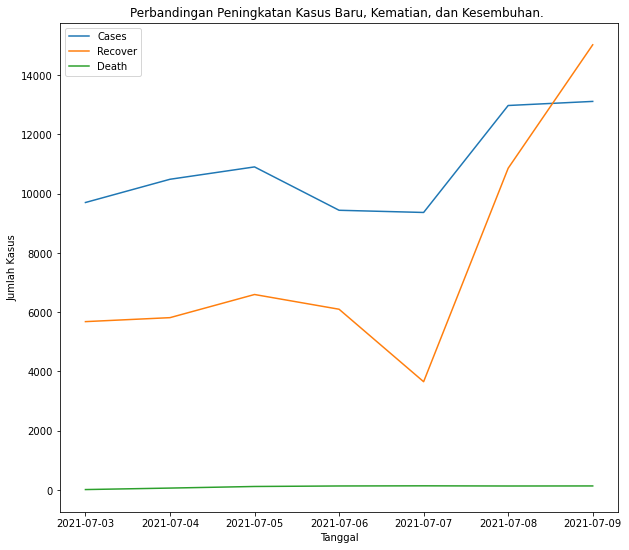

In [15]:
plt.figure(figsize=(10,9))
plt.plot(jakarta['Date'].values ,jakarta['New Cases'].values, label='Cases')
plt.plot(jakarta['Date'].values, jakarta['New Recovered'].values, label = 'Recover')
plt.plot(jakarta['Date'].values, jakarta['New Deaths'].values, label = 'Death')
plt.title('Perbandingan Peningkatan Kasus Baru, Kematian, dan Kesembuhan. ')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kasus')
plt.legend()
plt.show()

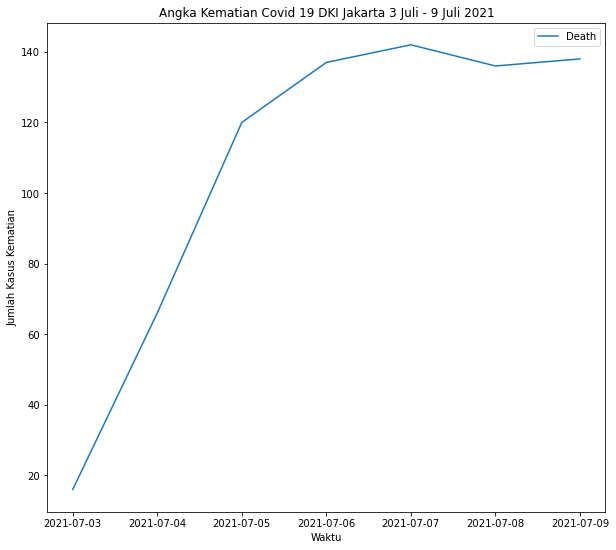

In [16]:
plt.figure(figsize=(10,9))
plt.plot(jakarta['Date'].values, jakarta['New Deaths'].values, label = 'Death')
plt.title('Angka Kematian Covid 19 DKI Jakarta 3 Juli - 9 Juli 2021')
plt.xlabel('Waktu')
plt.ylabel('Jumlah Kasus Kematian')
plt.legend()
plt.show()

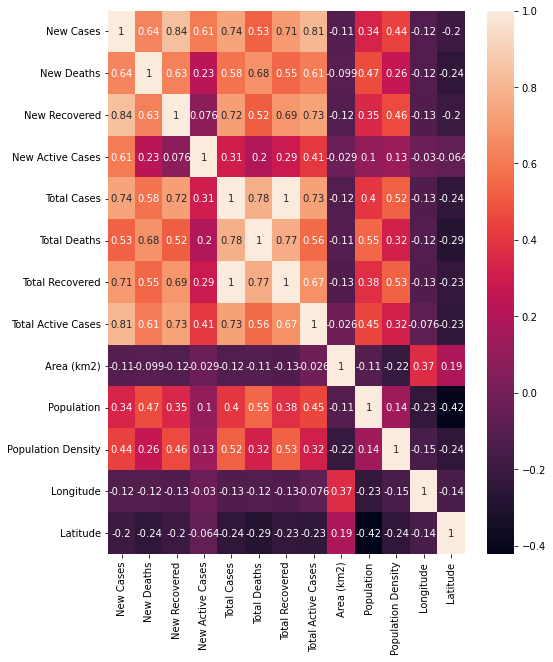

In [17]:
plt.figure(figsize=(8,10))
sns.heatmap(data1.corr(), annot=True)
plt.show()

In [18]:
data1.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude
0,2020-01-08,Jawa Timur,9,3,1,5,9,5,10,-6,Province,47803,40479023,846.78,112.732941,-7.723346
1,2020-01-09,Jawa Timur,0,1,23,-24,9,6,33,-30,Province,47803,40479023,846.78,112.732941,-7.723346
2,2020-01-10,Jawa Timur,0,1,14,-15,9,7,47,-45,Province,47803,40479023,846.78,112.732941,-7.723346
3,2020-01-11,Jawa Timur,0,3,8,-11,9,10,55,-56,Province,47803,40479023,846.78,112.732941,-7.723346
4,2020-01-12,Jawa Timur,0,3,1,-4,9,13,56,-60,Province,47803,40479023,846.78,112.732941,-7.723346


In [19]:
data2 = data1[['New Deaths', 'New Cases','Total Cases', 'New Recovered', 'Total Recovered', 'Total Deaths','Population', 'Population Density']]
data2.head()

,New Deaths,New Cases,Total Cases,New Recovered,Total Recovered,Total Deaths,Population,Population Density
0,3,9,9,1,10,5,40479023,846.78
1,1,0,9,23,33,6,40479023,846.78
2,1,0,9,14,47,7,40479023,846.78
3,3,0,9,8,55,10,40479023,846.78
4,3,0,9,1,56,13,40479023,846.78


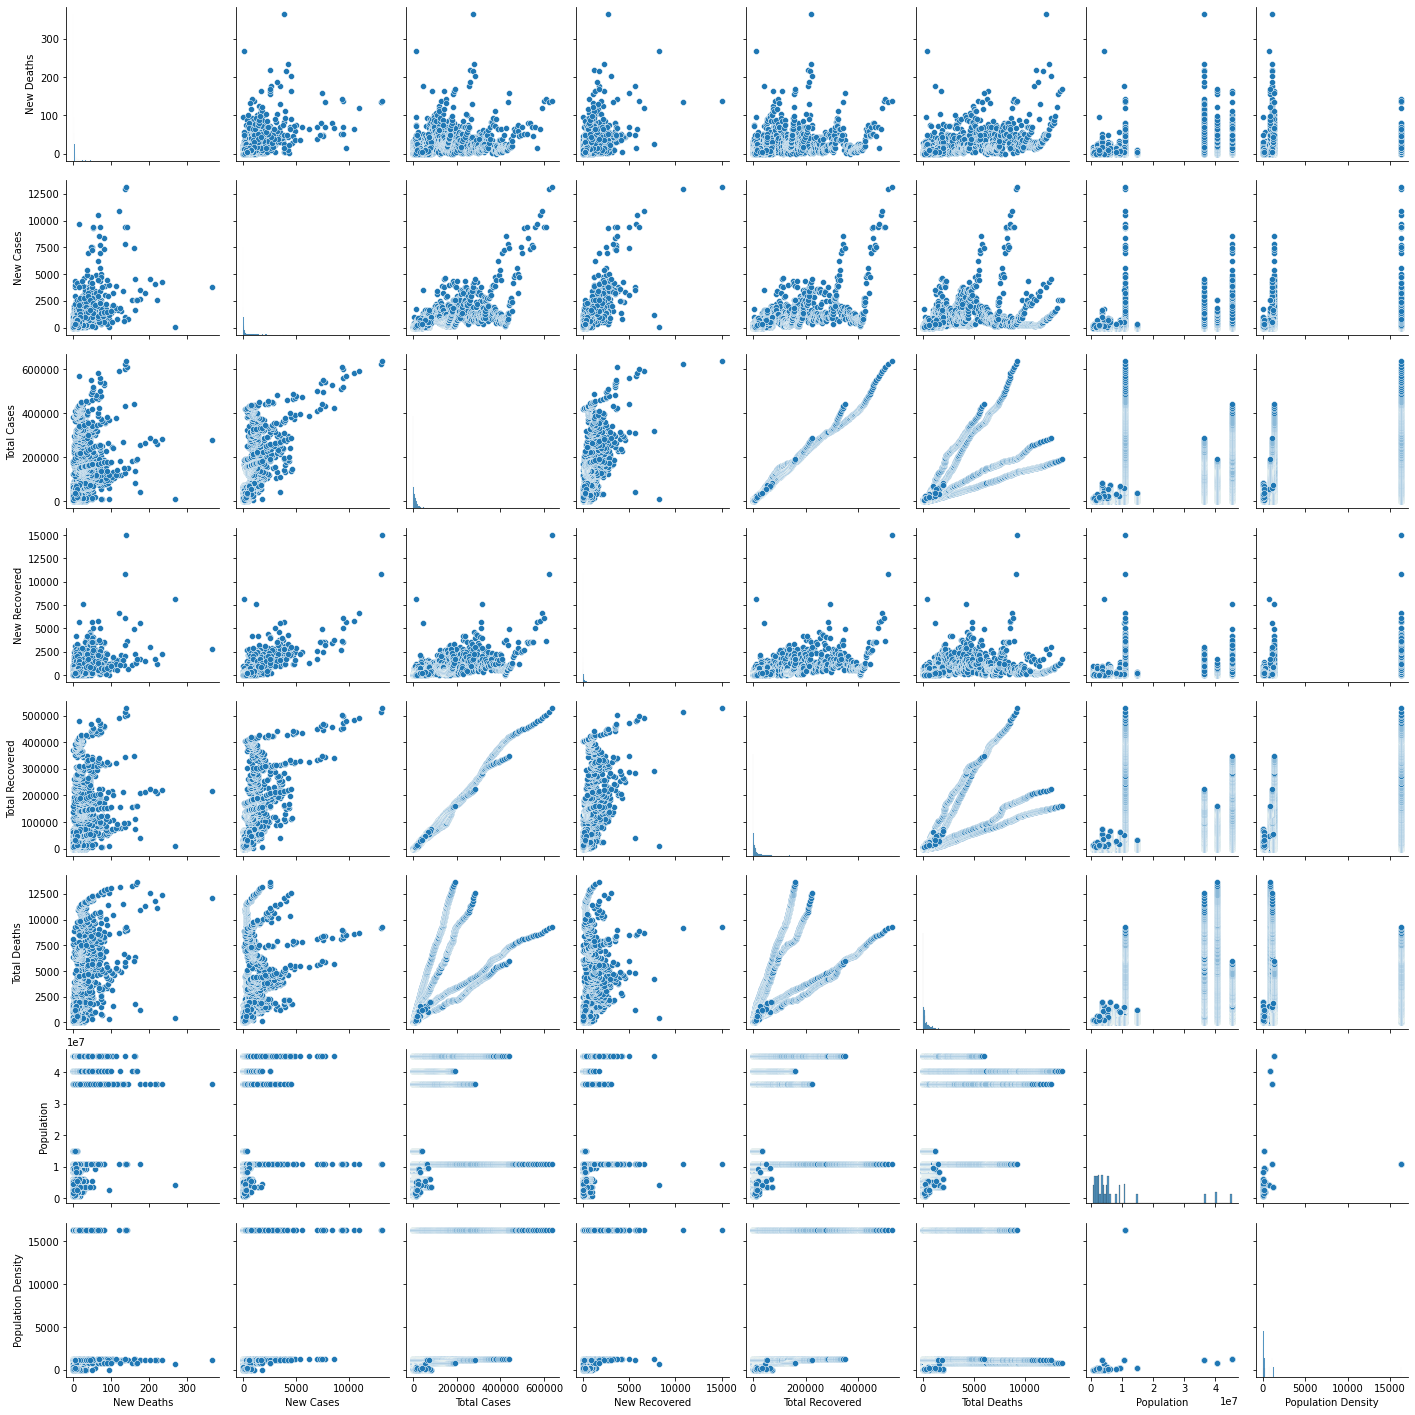

In [20]:
sns.pairplot(data2)
plt.show()

In [21]:
X = data2.drop('New Deaths', axis = 1)
y = data2['New Deaths']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11841, 7)
(3947, 7)
(11841,)
(3947,)


In [23]:
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [24]:
def predict_model(model, trainX, testX, trainY, testY):
    m = model
    m.fit(trainX, trainY)
    predict_m = m.predict(testX)
    print('-----------{}-----------'.format(model))
    print_evaluate(testY, predict_m)
    
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

In [25]:
model = [LinearRegression(), SVR(), DecisionTreeRegressor()]
for i in model:
    predict_model(i, X_train,X_test, y_train, y_test)

-----------LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)-----------
MAE: 2.484071559439131
MSE: 53.05080760219056
RMSE: 7.283598533842359
R2 Square 0.6093160909990689
__________________________________
-----------SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)-----------
MAE: 2.349695015887082
MSE: 67.08076616243825
RMSE: 8.190284864547646
R2 Square 0.5059947788233743
__________________________________
-----------DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')-----------
MAE: 2.6149818427497675
MSE: 59.8007

MAE: 2.484071559439131
MSE: 53.05080760219056
RMSE: 7.283598533842359
R2 Square 0.6093160909990689
__________________________________


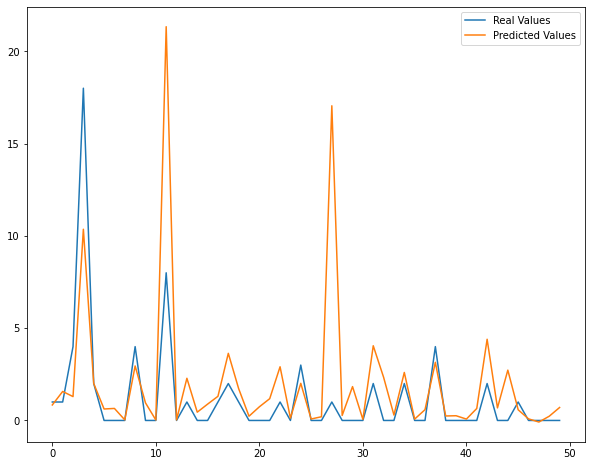

In [26]:
dct = LinearRegression()
dct.fit(X_train, y_train)

pred_dct = dct.predict(X_test)
print_evaluate(y_test, pred_dct)

df_dct = pd.DataFrame({'Real Values':y_test, 'Predicted Values':pred_dct})
df_dct.head()

plt.figure(figsize=(10,8))
plt.plot(df_dct['Real Values'].values[:50], label = 'Real Values')
plt.plot(df_dct['Predicted Values'].values[:50], label = 'Predicted Values')
plt.legend()
plt.show()

In [27]:
id_data = data[data['Location'] == 'Indonesia']
id_data.drop(['Date', 'Location', 'Longitude', 'Latitude','Location Level'], axis=1, inplace=True)
id_data

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Area (km2),Population,Population Density
56,2,0,0,2,2,0,0,2,1916907,265185520,138.34
61,0,0,0,0,2,0,0,2,1916907,265185520,138.34
66,0,0,0,0,2,0,0,2,1916907,265185520,138.34
71,0,0,0,0,2,0,0,2,1916907,265185520,138.34
77,2,0,0,2,4,0,0,4,1916907,265185520,138.34
...,...,...,...,...,...,...,...,...,...,...,...
16119,29745,558,14416,14771,2313829,61140,1942690,309999,1916907,265185520,138.34
16153,31189,728,15863,14598,2345018,61868,1958553,324597,1916907,265185520,138.34
16187,34379,1040,14835,18504,2379397,62908,1973388,343101,1916907,265185520,138.34
16221,38391,852,21185,16354,2417788,63760,1994573,359455,1916907,265185520,138.34


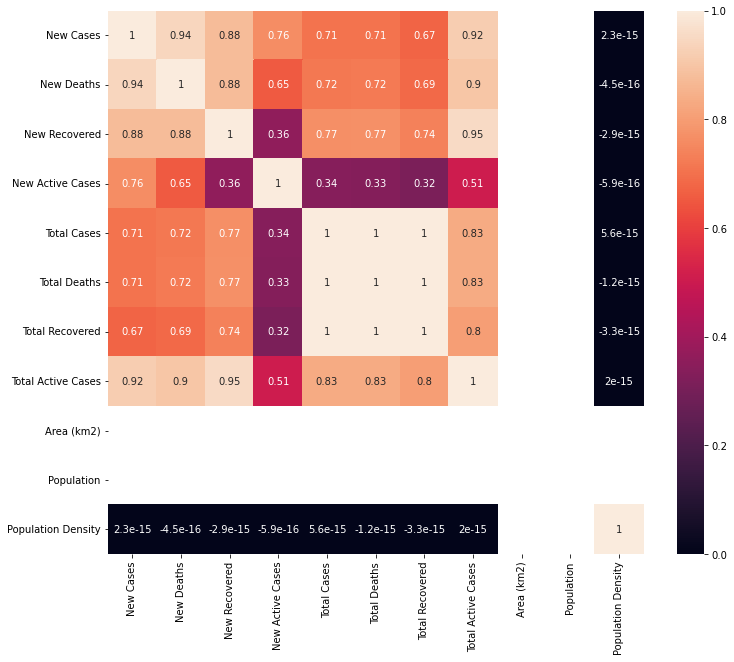

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(id_data.corr(), annot= True)

In [29]:
id_data.drop(['Area (km2)', 'Population', 'Population Density'], axis=1, inplace=True)
id_data.head()

,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases
56,2,0,0,2,2,0,0,2
61,0,0,0,0,2,0,0,2
66,0,0,0,0,2,0,0,2
71,0,0,0,0,2,0,0,2
77,2,0,0,2,4,0,0,4


In [30]:
X = id_data.drop('New Deaths', axis=1)
y = id_data['New Deaths']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(371, 7)
(124, 7)
(371,)
(124,)


In [32]:
#Scalling the Data, supaya nominal angka data bisa seragam (tidak terlalu besar Range-nya)
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [33]:
def predict_model(model, trainX, testX, trainY, testY):
    m = model
    m.fit(trainX, trainY)
    predict_m = m.predict(testX)
    print('-----------{}-----------'.format(model))
    print_evaluate(testY, predict_m)
    
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')


In [34]:
model = [LinearRegression(), SVR(), DecisionTreeRegressor()]
for i in model:
    predict_model(i, X_train,X_test, y_train, y_test)

-----------LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)-----------
MAE: 2.046821493657321e-12
MSE: 6.354635126436062e-24
RMSE: 2.5208401628100228e-12
R2 Square 1.0
__________________________________
-----------SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)-----------
MAE: 65.55274668927494
MSE: 20389.019157344173
RMSE: 142.79012275834828
R2 Square 0.16946116147006252
__________________________________
-----------DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')-----------
MAE: 29.524193548387096
MSE: 2475.6

MAE: 2.046821493657321e-12
MSE: 6.354635126436062e-24
RMSE: 2.5208401628100228e-12
R2 Square 1.0
__________________________________


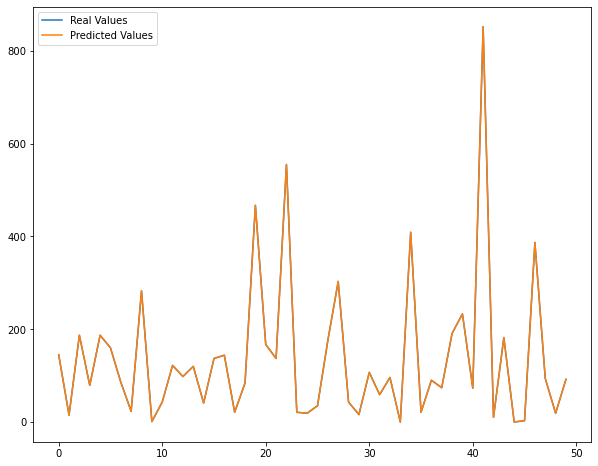

In [36]:
dct = LinearRegression()
dct.fit(X_train, y_train)

pred_dct = dct.predict(X_test)
print_evaluate(y_test, pred_dct)

df_dct = pd.DataFrame({'Real Values':y_test, 'Predicted Values':pred_dct})
df_dct.head()

plt.figure(figsize=(10,8))
plt.plot(df_dct['Real Values'].values[:50], label = 'Real Values')
plt.plot(df_dct['Predicted Values'].values[:50], label = 'Predicted Values')
plt.legend()
plt.show()